#### `Read/Extract Data from JSON files`

In [ ]:
import pandas as pd  #  import: bring in the pandas library and alias as pd
import re #  # import: bring in the regex library

# Step 1 :# Use a function (pd.read_json) to read JSON data from a file path (raw string r"" to treat backslashes literally)
# Extract the data from the customer JSON file (implemented a r-string/raw string because I want my backlash to be treated literally rather than as escape characters.)
customer_df = pd.read_json(r"C:\Users\cdw_sapp_customer.json") 

# Step 2: Modify DataFrame columns using string methods via pandas' vectorized str accessor
#  Transform the data name fields so it is readable
# Use assignment (=) to update columns
# Used string methods (title() & lower()) to transform the strings. 

customer_df['FIRST_NAME'] = customer_df['FIRST_NAME'].str.title() # Capitalized the first letter of first names
customer_df['MIDDLE_NAME'] = customer_df['MIDDLE_NAME'].str.lower() # Converted middle names to lowercase 
customer_df['LAST_NAME'] = customer_df['LAST_NAME'].str.title() # Capitalized the first letter of last names

# Step 3: Combine two columns into one using + operator (concatenate strings)
# astype(str) converts APT_NO from int/float to string explicitly
customer_df['FULL_STREET_ADDRESS'] = customer_df['STREET_NAME'] + ', ' + customer_df['APT_NO'].astype(str) # Makes it easier to load one address field into my SQL database 

# Step 4: Apply lambda functions to process each element in CUST_PHONE column
# lambda: defines an anonymous function with conditional logic (if...else)
customer_df['CUST_PHONE'] = customer_df['CUST_PHONE'].apply(lambda x: str(int(x)).zfill(10) if pd.notnull(x) else x)

# Further apply formatting or flag invalid phone numbers
customer_df['CUST_PHONE'] = customer_df['CUST_PHONE'].apply( 
    lambda x: f"({x[:3]}){x[3:6]}-{x[6:]}" if pd.notnull(x) and len(str(x)) == 10 else "Invalid" 
) # if not null and exactly 10 digits, format phone number string; else assign "Invalid"

# Step 5: Use to_csv method to export DataFrame as CSV file
customer_df.to_csv('transformed_customer_data.csv', index=False)  # index=False to exclude row numbers

# Step 6: Use print function to display the top 20 rows with head(20)
print(customer_df.head(20)) # function call to print output

# Use pd.to_datetime function to create a datetime column from YEAR, MONTH, DAY columns
credit_df = pd.read_json(r"C:\Users\cdw_sapp_credit.json")  # read JSON file into DataFrame


credit_df['TIMEID'] = pd.to_datetime(credit_df[['YEAR', 'MONTH', 'DAY']]) # Converted each day, year, and month into TIMEID 

credit_df.drop(['DAY', 'MONTH', 'YEAR'], axis=1, inplace=True) # Dropped the original columns
 
print(credit_df.head(20)) # Printed the first 20 rows. 

# Step 8: Read branch JSON file into DataFrame
branch_df = pd.read_json(r"C:\Users\cdw_sapp_branch.json")

# Convert BRANCH_PHONE column to string type, then pad zeros on the left to length 10 using str.zfill
branch_df['BRANCH_PHONE'] = branch_df['BRANCH_PHONE'].astype(str).str.zfill(10)

# Use apply + lambda to format phone numbers (string slicing and f-string formatting)
branch_df['BRANCH_PHONE'] = branch_df['BRANCH_PHONE'].apply(lambda x: f"({x[0:3]}){x[3:6]}-{x[6:]}")

# Print the first 20 rows of branch_df DataFrame
print(branch_df.head(20)) 


   FIRST_NAME MIDDLE_NAME  LAST_NAME        SSN    CREDIT_CARD_NO  APT_NO  \
0        Alec          wm     Hooper  123456100  4210653310061055     656   
1        Etta     brendan     Holman  123453023  4210653310102868     829   
2      Wilber    ezequiel     Dunham  123454487  4210653310116272     683   
3     Eugenio       trina      Hardy  123459758  4210653310195948     253   
4     Wilfred         may      Ayers  123454431  4210653310356919     301   
5        Beau     ambrose    Woodard  123454202  4210653310395982       3   
6      Sheila       larry       Kemp  123451799  4210653310400536      84   
7       Wendy         ora     Hurley  123453875  4210653310459911     728   
8        Alec      tracie    Gilmore  123457511  4210653310773972      81   
9      Barbra     mitchel        Lau  123457464  4210653310794854     561   
10    Edmundo       denny    Thomson  123457639  4210653310817373     622   
11       Elsa    isabelle     Truong  123453242  4210653310844617     924   

#### `Loading Data Into Database`

In [1]:
from pyspark.sql import SparkSession # Imported libraries 
# Creating a spark session
spark = SparkSession.builder \
    .appName("TestMySQLConnection") \
    .config("spark.jars", r"C:\path\to\mysql-connector-java-8.0.33.jar") \
    .getOrCreate()

# MySQL database connection
mysql_url = "jdbc:mysql://localhost:3306/creditcard_capstone"
# Connection properties
mysql_properties = {
    "user": "root",       
    "password": "password",  
    "driver": "com.mysql.cj.jdbc.Driver"
}


In [3]:
# Reads a JSON file into a spark df 
branch_df = spark.read.json( 
    # The r string makes it a raw string, so the backslashes aren't treated as escape characters. 
    r"C:\Users\cdw_sapp_branch.json",
    # Tells spark the JSON file contains one or more records spanning multiple lines. 
    multiLine=True
)

credit_df = spark.read.json(
    r"C:\Users\cdw_sapp_credit.json",
    multiLine=True
)

customer_df = spark.read.json(
    r"C:\Users\cdw_sapp_customer.json",
    multiLine=True
)


In [11]:
branch_df.printSchema()
branch_df.show(5, truncate=False)

credit_df.printSchema() 
credit_df.show(5, truncate=False)

customer_df.printSchema() 
customer_df.show(5, truncate=False)

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)

+-----------------+-----------+------------+------------+------------+-----------------+----------+-----------------------------+
|BRANCH_CITY      |BRANCH_CODE|BRANCH_NAME |BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET    |BRANCH_ZIP|LAST_UPDATED                 |
+-----------------+-----------+------------+------------+------------+-----------------+----------+-----------------------------+
|Lakeville        |1          |Example Bank|1234565276  |MN          |Bridle Court     |55044     |2018-04-18T16:51:47.000-04:00|
|Huntley          |2          |Example Bank|1234618993  |IL          |Washington Street|60142     |2018-04-18T16:51:47.000-04:00|


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CreditCardCapstone") \
    .config("spark.jars", r"C:\path\to\mysql-connector-java-8.0.33.jar") \
    .getOrCreate()

mysql_url = "jdbc:mysql://localhost:3306/creditcard_capstone"
mysql_properties = {
    "user": "root",       
    "password": "password",   
    "driver": "com.mysql.cj.jdbc.Driver"
}

branch_df = spark.read.json(r"C:\Users\cdw_sapp_branch.json", multiLine=True)
credit_df = spark.read.json(r"C:\Users\cdw_sapp_credit.json", multiLine=True)
customer_df = spark.read.json(r"C:\Users\cdw_sapp_customer.json", multiLine=True)

branch_df.write.jdbc(
    url=mysql_url,
    table="CDW_SAPP_BRANCH",
    mode="overwrite",
    properties=mysql_properties
)

credit_df.write.jdbc(
    url=mysql_url,
    table="CDW_SAPP_CREDIT_CARD",
    mode="overwrite",
    properties=mysql_properties
)

customer_df.write.jdbc(
    url=mysql_url,
    table="CDW_SAPP_CUSTOMER",
    mode="overwrite",
    properties=mysql_properties
)

print("All data written to MySQL successfully!")


All data written to MySQL successfully!


### `Creating CLI`

In [37]:
import mysql.connector # Connecting mySQL to python
from mysql.connector import Error # Used to catch or display any database connection or query-related issues. 

def get_transactions_by_zip_month_year(): # Performs the logic when called
    print(" Search Transactions by ZIP, Month & Year")

    # Step 1: Get ZIP
    while True:
        zip_code = input("Enter a 5-digit ZIP code: ").strip() # Prompts the user for a zip code
        if zip_code.isdigit() and len(zip_code) == 5: # Ensures it is exactly 5 digits
            break
        print(" Invalid ZIP code. Please enter exactly 5 digits.") # Keep prompting until the input is valid. 

    # Step 2: Get Month
    while True:
        month = input("Enter month 1-12: ").strip() # Prompts for the month (1-12) 
        if month.isdigit() and 1 <= int(month) <= 12: 
            month = int(month)
            break
        print("Invalid month. Please enter a number from 1 to 12.")

    # Step 3: Get Year
    while True:
        year = input("Enter year: ").strip() # Prompts the user for year
        if year.isdigit() and len(year) == 4:
            year = int(year) # Converts to a integer after validation 
            break
        print("Invalid year. Please enter a 4-digit year like 2018.")

    try:
        connection = mysql.connector.connect( # Try to connect to mySQL with these credentials 
            host='localhost',
            database='creditcard_capstone',
            user='root',       
            password='password'    
        )

        if connection.is_connected(): # Confirms connections ( In depth comments)
            cursor = connection.cursor(dictionary=True)

            query = """
    SELECT 
        c.CREDIT_CARD_NO,
        c.TRANSACTION_TYPE,
        c.TRANSACTION_VALUE,
        c.YEAR,
        c.MONTH,
        c.DAY
    FROM CDW_SAPP_CREDIT_CARD c
    JOIN CDW_SAPP_CUSTOMER cu ON c.CREDIT_CARD_NO = cu.CREDIT_CARD_NO
    WHERE cu.CUST_ZIP = %s
      AND c.MONTH = %s
      AND c.YEAR = %s
    ORDER BY c.DAY DESC;
"""

            cursor.execute(query, (zip_code, month, year))
            results = cursor.fetchall() # Gets all matching rows. 

            if results:
                print(f"\n Transactions for ZIP {zip_code} - {month:02}/{year}")
                for row in results:
                    print(f"{row['YEAR']}-{row['MONTH']:02}-{row['DAY']:02} | Amount: ${row['TRANSACTION_VALUE']} | Type: {row['TRANSACTION_TYPE']} | Card #: {row['CREDIT_CARD_NO']}")
            else:
                print(" No transactions found for that ZIP, month, and year.")

    except Error as e:
        print(" Database error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()


In [38]:
if __name__ == "__main__": # Checks if this script is being run directly. 
    get_transactions_by_zip_month_year() # Calls the function only when script is run directly


 Search Transactions by ZIP, Month & Year

 Transactions for ZIP 33602 - 02/2018
2018-02-08 | Amount: $46.21 | Type: Healthcare | Card #: 4210653310061055


In [ ]:
import mysql.connector # For connecting to MySQL database
import re               # For regex pattern matching 
import os               # For clearing the console screen

# Constants
ALLOWED_CUSTOMER_FIELDS = [ # Constant (list) #List of column names that are safe to update. # Python uses lists to store multiple values (in order). #It’s used inside conditionals to restrict user input.
    'FIRST_NAME', 'MIDDLE_NAME', 'LAST_NAME', 'CREDIT_CARD_NO',
    'STREET_NAME', 'CUST_CITY', 'CUST_STATE', 'CUST_COUNTRY', 
    'CUST_ZIP', 'CUST_PHONE', 'CUST_EMAIL'
]

def clear_screen():
    os.system('cls' if os.name == 'nt' else 'clear') # Clear the console screen for better readability

def pause():
    input("\nPress Enter to return to the main menu...") # Wait for user input before returning to the main menu

def connect_to_db():
    return mysql.connector.connect(
        host='localhost',
        port=3306,
        user='root',
        password='password',
        database='creditcard_capstone'
    )

# Utility for validated input
def get_validated_input(prompt, pattern, error_message): # prompt: what to show the user. # pattern: regex to validate input. # error_message: what to show if input is invalid
    while True: # Loop: while True → keeps asking until the input is valid.
        value = input(prompt).strip()  # Get input from user and remove leading/trailing whitespace
        if re.fullmatch(pattern, value): # Conditional: if re.fullmatch(...) → checks the format (like SSN = 9 digits).
            return value 
        else:
            print(error_message) # Print error message if input doesn't match the pattern.

# View customer account by SSN
def view_customer_info_by_ssn(conn, ssn): # ssn: Social Security Number, a unique identifier for customers.
    cursor = conn.cursor()
    query = "SELECT * FROM cdw_sapp_customer WHERE SSN = %s" # SQL query to fetch customer info by SSN
    cursor.execute(query, (ssn,))
    row = cursor.fetchone() # Fetch the first matching row from the database
    if row:
        columns = [desc[0] for desc in cursor.description] # Get column names from cursor description
        print("\n--- Customer Information ---") # Print header for customer info
        for col, val in zip(columns, row): # Pair each column name with its value
            print(f"{col}: {val}") # Print each column and its value
        print()
    else:
        print("No customer found with that SSN.\n")
    cursor.close()

# View customer with prompt
def view_customer_info(conn):
    ssn = get_validated_input("Enter Customer SSN (9 digits): ", r"\d{9}", "SSN must be 9 digits") # Regex pattern to validate SSN input
    view_customer_info_by_ssn(conn, ssn) # Call the function to view customer info by SSN

# Modify customer info
def modify_customer_details():
    clear_screen()
    ssn = input("Enter SSN of the customer to update: ") 
    field = input("Enter the field to update (e.g., email, phone): ").strip()
    value = input(f"Enter new value for {field}: ").strip()
    try:
        conn = connect_to_db()
        cursor = conn.cursor()
        query = f"UPDATE cdw_sapp_customer SET {field} = %s WHERE SSN = %s"
        cursor.execute(query, (value, ssn))
        conn.commit()
        print("Customer details updated successfully.")
        cursor.close()
        conn.close()
        pause()
    except Exception as e:
        print("Error:", e)
        pause()

# Generate monthly bill
def generate_monthly_bill(conn):
    card_number = input("Enter credit card number: ").strip()

    while True:
        try:
            month = int(input("Enter billing month (1-12): ").strip())
            if 1 <= month <= 12:
                break
            print("Month must be between 1 and 12.")
        except ValueError:
            print("Invalid input. Enter a number.")

    year = int(input("Enter billing year (e.g., 2024): ").strip())

    cursor = conn.cursor()
    query = """
    SELECT t.TRANSACTION_ID, t.DAY, t.MONTH, t.YEAR, t.CUST_SSN, t.CREDIT_CARD_NO,
           t.CUST_ZIP, t.TRANSACTION_TYPE, t.TRANSACTION_VALUE, t.BRANCH_CODE
    FROM credit_card t
    WHERE t.CREDIT_CARD_NO = %s AND t.MONTH = %s AND t.YEAR = %s
    ORDER BY t.YEAR DESC, t.MONTH DESC, t.DAY DESC
    """
    try:
        cursor.execute(query, (card_number, month, year))
        transactions = cursor.fetchall()
        total = sum(row[8] for row in transactions)

        print(f"\n--- Monthly Bill for Card {card_number} ({month:02d}/{year}) ---")
        print(f"Total Due: ${total:.2f}")
        print("\nTransactions:")
        for row in transactions:
            print(f"Date: {row[3]:04d}-{row[2]:02d}-{row[1]:02d}, Amount: ${row[8]:.2f}, Type: {row[7]}")
        print()
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
    finally:
        cursor.close()

# Transactions between two dates
def get_transactions_by_date_range(conn):
    ssn = get_validated_input("Enter Customer SSN (9 digits): ", r"\d{9}", "SSN must be 9 digits")
    start_date = input("Enter start date (YYYY-MM-DD): ").strip()
    end_date = input("Enter end date (YYYY-MM-DD): ").strip()

    cursor = conn.cursor()
    query = """
    SELECT YEAR, MONTH, DAY, TRANSACTION_VALUE, TRANSACTION_TYPE
    FROM credit_card
    WHERE CUST_SSN = %s AND STR_TO_DATE(CONCAT(YEAR, '-', MONTH, '-', DAY), '%%Y-%%m-%%d')
          BETWEEN %s AND %s
    ORDER BY YEAR DESC, MONTH DESC, DAY DESC
    """
    try:
        cursor.execute(query, (ssn, start_date, end_date))
        results = cursor.fetchall()

        if not results:
            print("\nNo transactions found for the given date range.\n")
        else:
            print("\n--- Transactions Between Dates ---")
            for row in results:
                print(f"Date: {row[0]:04d}-{row[1]:02d}-{row[2]:02d}, Amount: ${row[3]:.2f}, Type: {row[4]}")
            print()
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
    finally:
        cursor.close()

# Placeholder for unimplemented functions
def get_transactions(conn):
    print("Function not implemented yet.")

def get_customer_months_years(conn):
    print("Function not implemented yet.")

# Main Menu
def main():
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="password",  # Replace with your actual password
            database="creditcard_capstone"
        )
    except mysql.connector.Error as err:
        print(f"Failed to connect to database: {err}")
        return

    while True:
        print("\n--- Main Menu ---")
        print("1. View Transaction Dates by Zip/Month/Year")
        print("2. View Customer's Transaction Months/Years by SSN")
        print("3. View Existing Customer Account")
        print("4. Modify Customer Account Info")
        print("5. Generate Monthly Bill")
        print("6. View Transactions Between Two Dates")
        print("7. Exit")

        choice = input("Choose an option: ").strip()

        if choice == "1":
            get_transactions(conn)
        elif choice == "2":
            get_customer_months_years(conn)
        elif choice == "3":
            view_customer_info(conn)
        elif choice == "4":
            modify_customer_details()
        elif choice == "5":
            generate_monthly_bill(conn)
        elif choice == "6":
            get_transactions_by_date_range(conn)
        elif choice == "7":
            print("Exiting the program. Goodbye!")
            break
        else:
            print("Invalid choice. Please try again.")

    conn.close()

if __name__ == "__main__":
    main()



--- Main Menu ---
1. View Transaction Dates by Zip/Month/Year
2. View Customer's Transaction Months/Years by SSN
3. View Existing Customer Account
4. Modify Customer Account Info
5. Generate Monthly Bill
6. View Transactions Between Two Dates
7. Exit
Customer details updated successfully.

--- Main Menu ---
1. View Transaction Dates by Zip/Month/Year
2. View Customer's Transaction Months/Years by SSN
3. View Existing Customer Account
4. Modify Customer Account Info
5. Generate Monthly Bill
6. View Transactions Between Two Dates
7. Exit
Function not implemented yet.

--- Main Menu ---
1. View Transaction Dates by Zip/Month/Year
2. View Customer's Transaction Months/Years by SSN
3. View Existing Customer Account
4. Modify Customer Account Info
5. Generate Monthly Bill
6. View Transactions Between Two Dates
7. Exit
Customer details updated successfully.

--- Main Menu ---
1. View Transaction Dates by Zip/Month/Year
2. View Customer's Transaction Months/Years by SSN
3. View Existing Custo

### ` Data Analysis + Visualization`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_14932\3219557922.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  credit_db = pd.read_sql(query, conn) # Executes the SQL query and loads the results into a pandas DataFrame called df


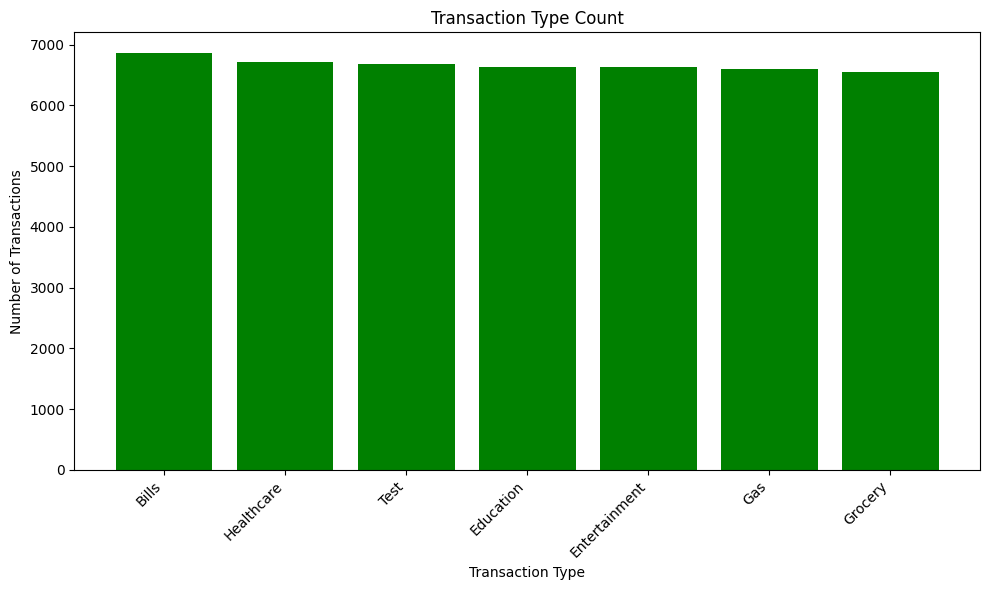

In [42]:
import mysql.connector # Lets you connect to and query a MySQL database
import pandas as pd # Used for data manipulation and to easily load SQL query results into a DataFrame
import matplotlib.pyplot as plt # Used to create the bar chart.

# Connect to database
conn = mysql.connector.connect( # Establishes a connection to MySQL database running on local machine.
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

query = """
SELECT TRANSACTION_TYPE, COUNT(*) AS count # Selects each unique TRANSACTION_TYPE # Counts how many times each type appears
FROM CDW_SAPP_CREDIT_CARD
GROUP BY TRANSACTION_TYPE # Groups the results by TRANSACTION_TYPE
ORDER BY count DESC; # Sorts them in descending order (most frequent first)
"""
credit_db = pd.read_sql(query, conn) # Executes the SQL query and loads the results into a pandas DataFrame called df
conn.close() # Closes the database connection

plt.figure(figsize=(10, 6)) # Sets the figure size of the plot to 10 inches wide and 6 inches tall.

# Plot the bar chart
plt.bar(credit_db['TRANSACTION_TYPE'], credit_db['count'], color='green') # Creates a vertical bar chart. # The x-axis shows each TRANSACTION_TYPE. # The y-axis shows the corresponding count. # Bars are colored green.
plt.title('Transaction Type Count') # Adds a title and axis labels to the chart for better readability.
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')  # Rotates the x-axis labels by 45 degrees # Aligns them to the right (ha='right') to prevent overlapping if names are long.

plt.tight_layout() # Adjusts spacing to prevent elements from being cut off.
plt.show() # Displays the chart 


C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_14932\3347056353.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  credit_db = pd.read_sql(query, conn)


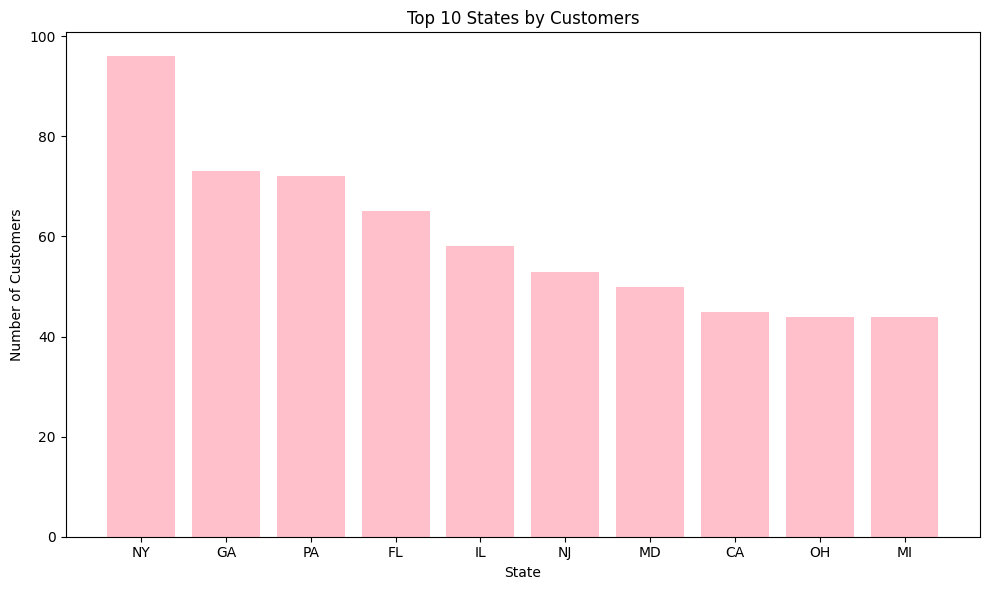

In [44]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt # Bar plot with matplotlib directly for more control

# Connect to the database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

# Query the database
query = """
SELECT CUST_STATE, COUNT(*) AS count
FROM CDW_SAPP_CUSTOMER
GROUP BY CUST_STATE
ORDER BY count DESC
LIMIT 10;
"""

credit_db = pd.read_sql(query, conn)
conn.close()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(credit_db['CUST_STATE'], credit_db['count'], color='pink') # Bars are colored pink 
plt.xticks(rotation=0)  # Rotating x-axis labels for better readability 

# Labeling
plt.xlabel('State') # Adding x-axis labels 
plt.ylabel('Number of Customers') # Adding y-axis labels
plt.title('Top 10 States by Customers') # Graph title 

plt.tight_layout()
plt.show() # Displaying the graph 


C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_14932\2137630172.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query3, conn)


    CUSTOMER_NAME  TOTAL_SPENT
0         Ty Daly      5633.07
1  Jessie Boucher      5548.14
2   Phoebe Martin      5476.08
3    Thurman Vera      5314.97
4    Bret Perkins      5261.03


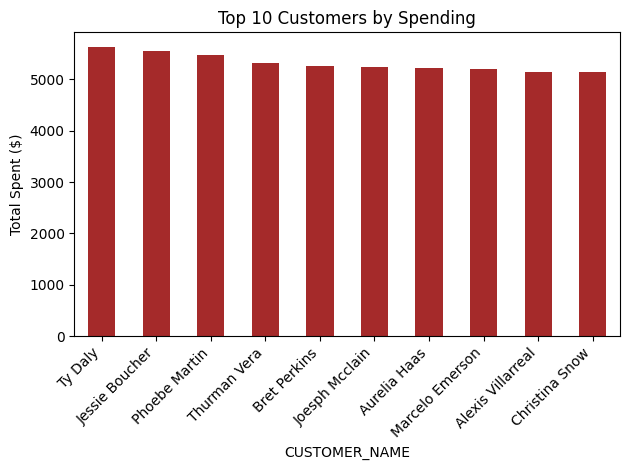

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

# Open connection
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

# Define query
query3 = """
SELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS CUSTOMER_NAME, SUM(TRANSACTION_VALUE) AS TOTAL_SPENT
FROM CDW_SAPP_CREDIT_CARD AS cc
JOIN CDW_SAPP_CUSTOMER AS cu ON cc.CUST_SSN = cu.SSN
GROUP BY CUSTOMER_NAME
ORDER BY TOTAL_SPENT DESC
LIMIT 10;
"""

# Load data
df3 = pd.read_sql(query3, conn)

# Preview
print(df3.head())

# Plot
df3.plot(kind='bar', x='CUSTOMER_NAME', y='TOTAL_SPENT', title='Top 10 Customers by Spending', color = 'Brown', legend=False)
plt.ylabel('Total Spent ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("top_10_customers_by_spending")  # added extension
plt.show()

# Close connection
conn.close()


### `Loading Loan Application Data API Into MySQL`

In [ ]:
import requests # Importing requests to get data from a web API 
from pyspark.sql import SparkSession # Importing SparkSession to create a Spark session

# Create Spark session
spark = SparkSession.builder \
    .appName("Loan Application ETL") \
    .getOrCreate() 


# Step 1: Read API data
response = requests.get("https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json")  # Fetches data from the specified URL (API endpoint) and stores it in response variable.

# Step 2: Print status code
print("Status Code:", response.status_code) # Displays the status code of the API response ( # 200 = success)

# Step 3: If OK, convert JSON to PySpark DataFrame and load to MySQL
if response.status_code == 200:  # Checks if the API request was successful (code 200)
    data = response.json()  # Converts the JSON response (text format) into a Python dictionary or list so it can be processed.

    # Step 4: Use existing Spark session (spark is already defined)
    # Step 5: Create Spark DataFrame from JSON data
    dataframe = spark.read.json(spark.sparkContext.parallelize(data))

    mysql_url = "jdbc:mysql://localhost:3306/creditcard_capstone"  # MySQL database URL (host, port, and database name)

    mysql_properties = {
        "user": "root",               # Replace with your MySQL username
        "password": "password",       # Replace with your MySQL password
        "driver": "com.mysql.cj.jdbc.Driver"  # Make sure this driver is in your classpath
    }

    # Step 6: Write to MySQL
    dataframe.write \
        .format("jdbc") \
        .option("url", mysql_url) \
        .option("dbtable", "CDW_SAPP_loan_application") \
        .option("user", mysql_properties["user"]) \
        .option("password", mysql_properties["password"]) \
        .option("driver", mysql_properties["driver"]) \
        .mode("overwrite") \
        .save()  # actually writes the data.

    print("Data loaded to MySQL!") # Indicates that the data has been successfully loaded into the MySQL database.
else:
    print("Failed to fetch data.") # Prints an error message if the API request was not successful.





Status Code: 200
Data loaded to MySQL!


### `Data Analysis & Visualization for Loan Application`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_14932\1306089678.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  credit_db = pd.read_sql(query, conn)


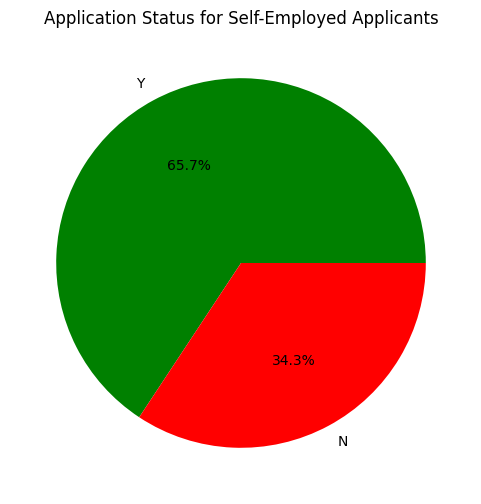

In [ ]:
# Imported the Pandas library for data handling and Matplotlib for plotting
import pandas as pd
import matplotlib.pyplot as plt # Pie chart to visualize the percentage of loan applications approved for self-employed applicants.
import mysql.connector # For connecting to MySQL database


# Connect to the database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",        
    database="creditcard_capstone"
)

# Define the SQL query to fetch self-employed applicants and their application status
query = """
SELECT Self_Employed, Application_Status    # Selects the Self_Employed status and Application_Status from the loan application table
FROM CDW_SAPP_LOAN_APPLICATION
"""

# Execute the query and load the results into a DataFrame
credit_db = pd.read_sql(query, conn)

conn.close()


plt.figure(figsize=(6, 6)) # Sets the size of the plot to be 6 inches by 6 inches.
status_counts = df[df['Self_Employed'] == "Yes"]['Application_Status'].value_counts() # Filters the DataFrame to include only self-employed applicants and counts the occurrences of each application status.
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['green', 'red']) # Creates a pie chart with the counts of application statuses for self-employed applicants.
plt.title('Application Status for Self-Employed Applicants') # Adds a title to the pie chart. 
plt.savefig('self_employed_approval_percentage')  # Save the plot with proper name
plt.show() # Displays the pie chart showing the percentage of loan applications approved for self-employed applicants.


## Credit Card Visualizations

### `Line Chart Visualization: Total credit card spending by month`

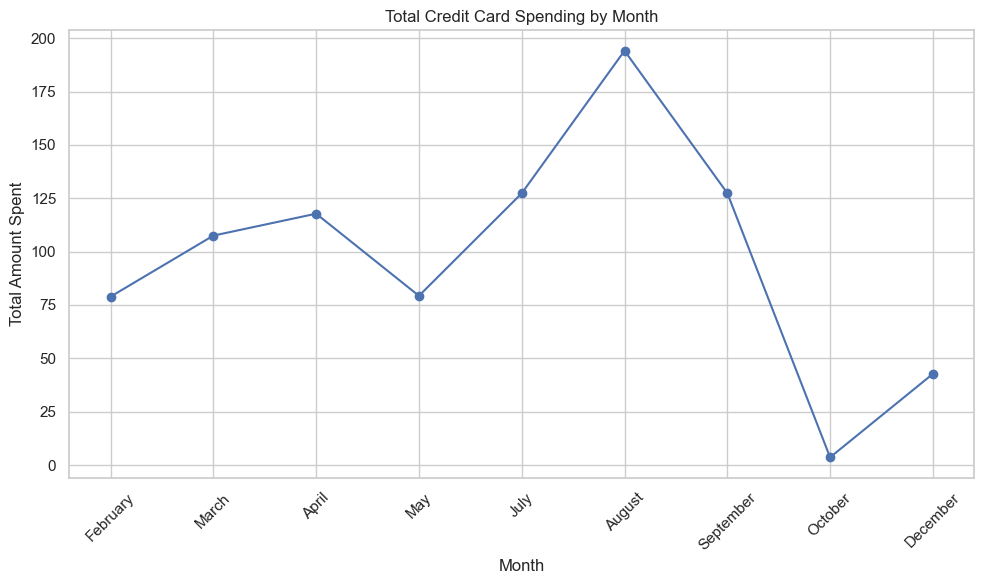

In [ ]:
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting the bar chart
import seaborn as sns  # For enhanced visualization with seaborn
import calendar  # To convert month numbers to month names

sns.set(style="whitegrid")  # Set the style of seaborn plots to "whitegrid" for better aesthetics

# Credit card transaction data
credit_data = pd.DataFrame({
    "Month": [2, 3, 7, 4, 10, 5, 5, 8, 3, 9, 8, 12, 4, 4, 5, 7, 9],
    "Amount": [
        78.9, 14.24, 56.7, 59.73, 3.59, 6.89, 43.39, 95.39, 93.26, 100.38,
        98.75, 42.71, 40.24, 17.81, 29.0, 70.63, 27.04
    ]
})

# Group by month and sum the amounts
monthly_spending = credit_data.groupby("Month")["Amount"].sum().reset_index()

# Map month numbers to month names
monthly_spending["Month"] = monthly_spending["Month"].apply(lambda x: calendar.month_name[x])

# Sort months in calendar order
monthly_spending["Month"] = pd.Categorical(
    monthly_spending["Month"],
    categories=list(calendar.month_name)[1:],  # Exclude empty string at index 0
    ordered=True
)
monthly_spending = monthly_spending.sort_values("Month")

# Line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_spending["Month"], monthly_spending["Amount"], marker='o')
plt.title("Total Credit Card Spending by Month")
plt.xlabel("Month")
plt.ylabel("Total Amount Spent")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

""" 
The line chart effectively visualizes the trend of credit card spending over the months, allowing for easy identification of spending patterns and seasonal variations.
"""

### `Bar Chart Visualization: Spending by Category `

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_2996\2335317799.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_spending, x="Amount", y="Category", palette="viridis")


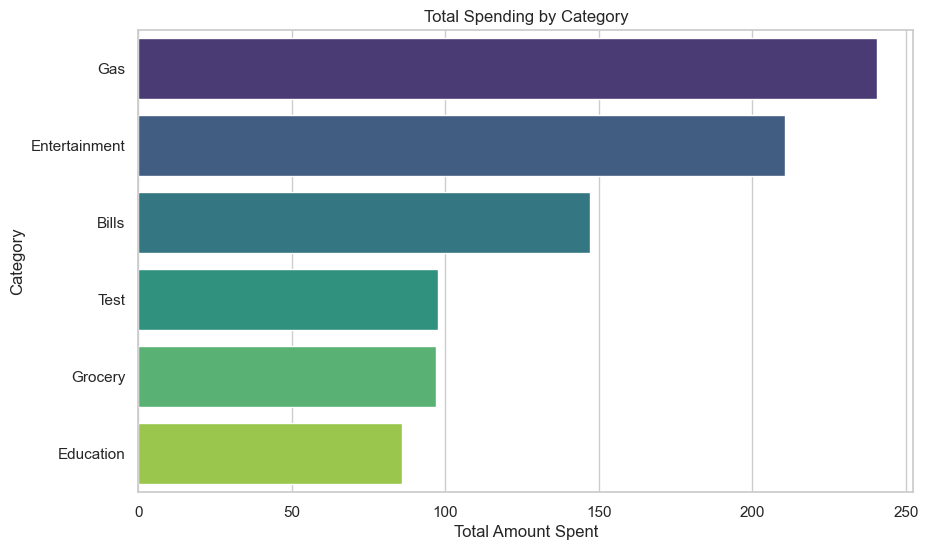

In [ ]:
# Category spending data 
credit_data["Category"] = [
    "Education", "Entertainment", "Grocery", "Entertainment", "Gas", "Education", "Entertainment",
    "Gas", "Entertainment", "Bills", "Gas", "Gas", "Grocery", "Bills", "Bills", "Test", "Test"
]

category_spending = credit_data.groupby("Category")["Amount"].sum().sort_values(ascending=False).reset_index() # Sorts the total spending by category in descending order and resets the index for better readability.

# Bar chart
plt.figure(figsize=(10, 6)) # Creates a new figure with a specified size of 10 inches wide and 6 inches tall.
sns.barplot(data=category_spending, x="Amount", y="Category", palette="viridis") # Creates a horizontal bar chart using seaborn's barplot function. The x-axis represents the total amount spent, and the y-axis represents the categories.
plt.title("Total Spending by Category") # Adds a title to the bar chart.
plt.xlabel("Total Amount Spent") # Adds a label to the x-axis.
plt.ylabel("Category") # Adds a label to the y-axis.
plt.show() # Displays the bar chart showing total spending by category.

""" The bar chart provides a clear comparison of spending across different categories, highlighting which categories have the highest total spending.
"""


### `Heatmap Visualization: Monthly Spending by Category`

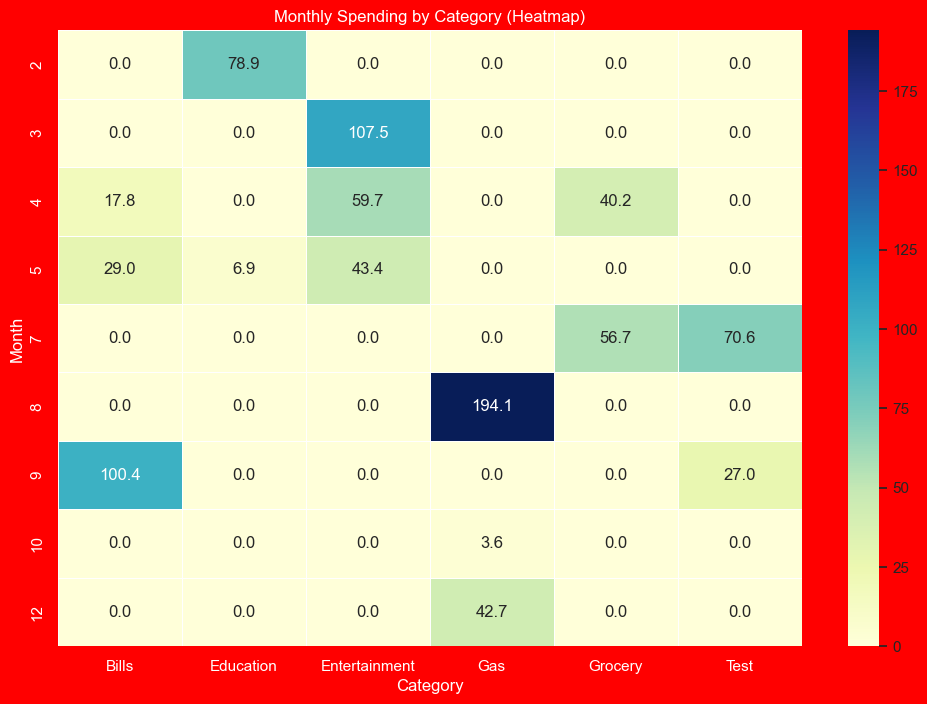

In [ ]:
monthly_category = credit_data.groupby(["Month", "Category"])["Amount"].sum().unstack(fill_value=0) # Reshape the data to have months as rows and categories as columns, filling missing values with 0

# Heatmap
fig, ax = plt.subplots(figsize=(12, 8)) # Create a figure and axes for the heatmap
fig.patch.set_facecolor('red') # Set the background color of the figure to red 
ax.set_facecolor('red') # Set the background color of the axes to red
sns.heatmap(monthly_category, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, ax=ax)
plt.title("Monthly Spending by Category (Heatmap)", color='white') # Set the title color to white
plt.xlabel("Category", color='white') # Set the x-axis label color to white
plt.ylabel("Month", color = 'white') # Set the y-axis label color to white

ax.tick_params(colors='white') # Change the color of the tick labels to white
plt.show() # Displays the heatmap showing monthly spending by category with a red background.


""" The heatmap provides a visual representation of how spending varies across different categories and months, making it easy to identify trends and patterns in spending behavior.
"""


## Loan Application Visualizations

### `Loan Approval Rates by Income Bracket`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_2996\190640923.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


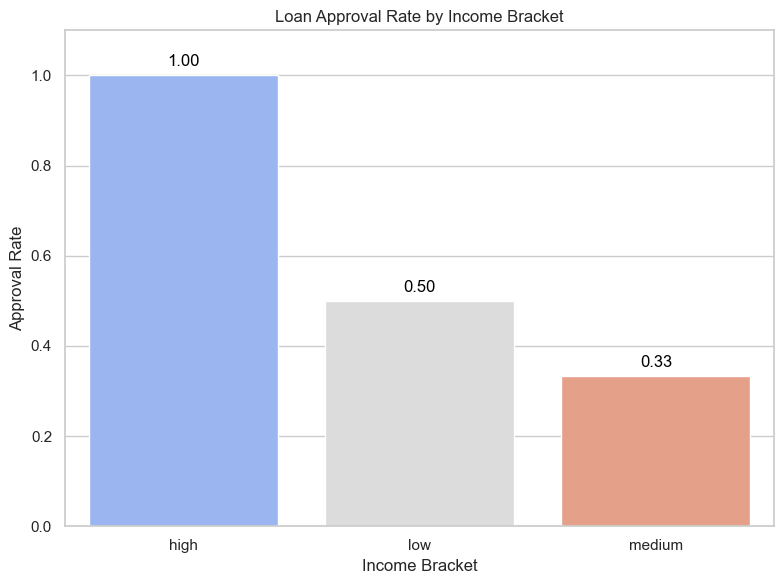

In [ ]:
import matplotlib.pyplot as plt # For plotting the bar chart
import pandas as pd # For data manipulation and analysis
import seaborn as sns # For enhanced visualization with seaborn

# Reset plot style
sns.set(style="whitegrid") # Set the style of seaborn plots to "whitegrid" for better aesthetics

# Plot approval rate
plt.figure(figsize=(8, 6)) # Sets the figure size to 8 inches wide and 6 inches tall.
bar = sns.barplot(
    x=income_loan.index,
    y=income_loan["Approval_Rate"],
    palette="coolwarm"
)

# Add value labels above bars
for index, value in enumerate(income_loan["Approval_Rate"]):
    bar.text(index, value + 0.02, f"{value:.2f}", ha='center', color='black') # Adds text labels above each bar showing the approval rate with 2 decimal places.

plt.title("Loan Approval Rate by Income Bracket") # Adds a title to the bar chart.
plt.xlabel("Income Bracket") # Adds a label to the x-axis.
plt.ylabel("Approval Rate") # Adds a label to the y-axis.
plt.ylim(0, 1.1) # Sets the y-axis limits from 0 to 1.1 to provide some space above the highest bar for better visibility of labels.
plt.tight_layout() # Adjusts the layout to prevent overlapping elements.
plt.show() # Displays the bar chart showing the loan approval rate by income bracket with value labels above each bar.

""" The bar chart effectively visualizes the loan approval rates across different income brackets, allowing for easy comparison and identification of trends in approval rates based on income levels.
"""

### ``

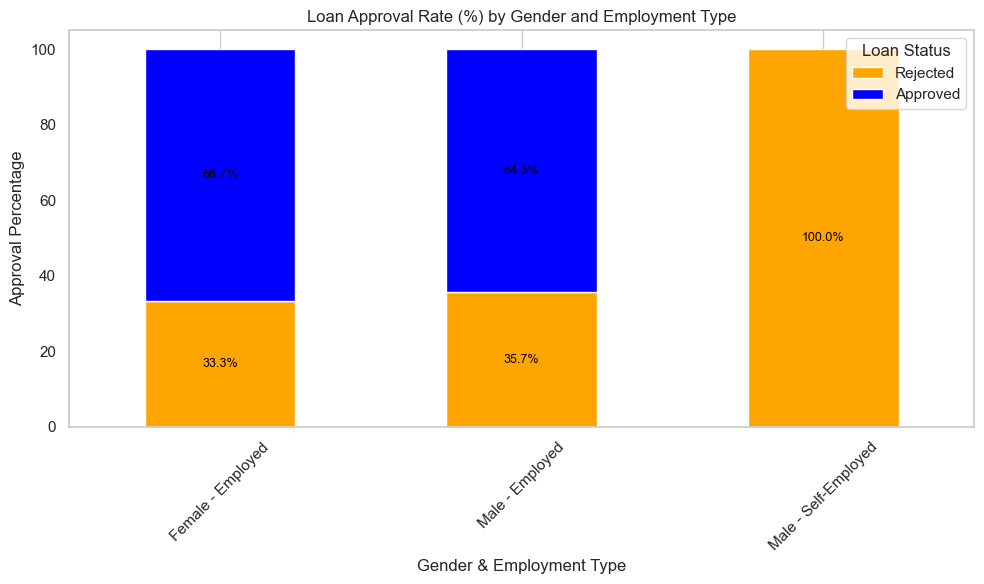

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample loan application data
loan_data = pd.DataFrame({
    "Loan_Status": ['N', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y'], 
    "Self_Employed": ['Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
    "Gender": ['Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Male']           
})

# Clean and prepare data
loan_data["Loan_Status"] = loan_data["Loan_Status"].str.upper().str.strip()
loan_data["Self_Employed"] = loan_data["Self_Employed"].str.title().str.strip()
loan_data["Gender"] = loan_data["Gender"].str.title().str.strip()
loan_data["Employment_Type"] = loan_data["Self_Employed"].map({'No': 'Employed', 'Yes': 'Self-Employed'})
loan_data["Group"] = loan_data["Gender"] + " - " + loan_data["Employment_Type"]

# Calculate approval/rejection percentages
grouped = loan_data.groupby(["Group", "Loan_Status"]).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
ax = grouped_percent[['N', 'Y']].plot(
    kind='bar',
    stacked=True,
    color=['orange', 'blue'],
    figsize=(10, 6)
)

plt.title("Loan Approval Rate (%) by Gender and Employment Type")
plt.xlabel("Gender & Employment Type")
plt.ylabel("Approval Percentage")
plt.xticks(rotation=45)
plt.legend(title="Loan Status", labels=["Rejected", "Approved"])
plt.grid(axis='y')

# Add percentage labels on each stacked segment
for i, (index, row) in enumerate(grouped_percent.iterrows()):
    y_offset = 0
    for status in ['N', 'Y']:
        value = row[status]
        if value > 0:
            ax.text(i, y_offset + value / 2, f"{value:.1f}%", ha='center', va='center', fontsize=9, color='black')
            y_offset += value

plt.tight_layout()
plt.show()

""" The stacked bar chart provides a clear visual representation of loan approval rates
"""

### `Loan Rejection By Property Area`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_2996\1668747321.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rejection_counts.index, fontsize=11)


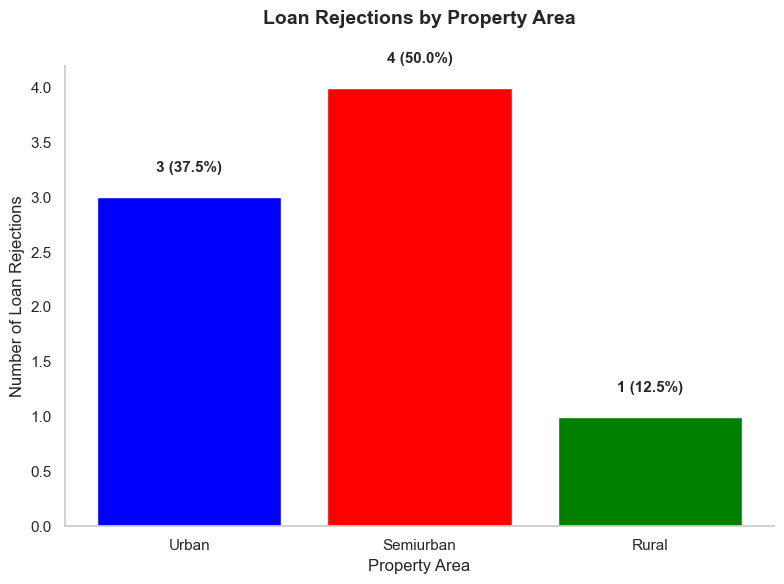

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Input data
loan_status = ['N', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y']
property_area = [
    'Semiurban', 'Urban', 'Urban', 'Urban', 'Semiurban', 'Urban', 'Urban', 'Rural', 'Urban',
    'Semiurban', 'Rural', 'Semiurban', 'Rural', 'Semiurban', 'Semiurban', 'Urban', 'Rural', 'Urban'
]

# Create DataFrame
df = pd.DataFrame({
    "Loan_Status": loan_status,
    "Property_Area": property_area[:len(loan_status)]
})

# Filter rejections only
rejections = df[df["Loan_Status"] == "N"]

# Count rejections by property area, fixed order
rejection_counts = rejections["Property_Area"].value_counts().reindex(['Urban', 'Semiurban', 'Rural'])

# Calculate percentages
total_rejections = rejection_counts.sum()
rejection_percentages = (rejection_counts / total_rejections) * 100

# Colors per area
colors = ['blue', 'red', 'green']  # Urban, Semiurban, Rural

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Bars
bars = ax.bar(rejection_counts.index, rejection_counts.values, color=colors)

# Title and labels
ax.set_title("Loan Rejections by Property Area", fontsize=14, fontweight='bold', pad=30)  # increased padding for clarity
ax.set_xlabel("Property Area", fontsize=12)
ax.set_ylabel("Number of Loan Rejections", fontsize=12)
ax.set_xticklabels(rejection_counts.index, fontsize=11)
ax.tick_params(axis='y', labelsize=11)

# Remove grid lines
ax.grid(False)

# Show only left and bottom spines for clarity
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Add labels with counts and percentages closer to bars (offset 0.2)
for bar, count, pct in zip(bars, rejection_counts.values, rejection_percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{count} ({pct:.1f}%)", 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

""" The bar chart effectively visualizes the number of loan rejections by property area, with clear labels showing both counts and percentages for each area. The use of distinct colors for each property area enhances readability and understanding of the data.
"""